In [449]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf
#!pip install polars
#!pip install catboost
#!pip install optuna

# 2023.04.06

Dataset Info.

    train.csv [파일]
    1,000,000개의 데이터
    ID : 샘플 고유 id
    항공편 운항 관련 정보
    Delay: 항공편 지연 여부 (Not_Delayed, Delayed)
    예측해야 하는 타깃
    다수의 데이터에 레이블이 존재하지 않음
    준지도학습을 통해 레이블링 가능


    test.csv [파일]
    1,000,000개의 데이터
    ID : 샘플 고유 id
    항공편 운항 관련 정보

    Estimated_Departure_Time: 예상 출발 시간
    Estimated_Arrival_Time : 예상 도착 시간
    Carrier_Code(IATA) : 위치 식별 코드 (공항코드)
    Carrier_ID(DOT) : 몰?루
    Tail_Number : 항공기 특수 번호 (맨앞자리 영어가 원산지)
    Carrier : 항공회사 


In [450]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [451]:
file_dir = '/content/drive/MyDrive/데이콘/데이콘 항공편 지연/데이콘_항공편_지연'

In [452]:
import numpy as np
import random
import os
import gc

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [453]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [454]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [455]:
csv_to_parquet(file_dir + '/train.csv', 'train')
csv_to_parquet(file_dir + '/test.csv', 'test')

train Done.
test Done.


In [456]:
train = pd.read_parquet('/content/train.parquet')
test = pd.read_parquet('/content/test.parquet')
sample_submission = pd.read_csv(file_dir+'/sample_submission.csv', index_col = 0)

In [457]:
train.head(10)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None
5,TRAIN_000005,4,13,1545.0,NaN,0,0,EWR,11618,None,DCA,11278,Virginia,199.0,Republic Airlines,UA,20452.0,N657RW,Not_Delayed
6,TRAIN_000006,1,20,1742.0,1903.0,0,0,EWR,11618,New Jersey,BOS,10721,Massachusetts,200.0,United Air Lines Inc.,UA,NaN,N66825,Not_Delayed
7,TRAIN_000007,4,20,1815.0,1955.0,0,0,ORD,13930,Illinois,MCI,13198,Missouri,403.0,None,UA,20304.0,N110SY,None
8,TRAIN_000008,6,13,1420.0,1550.0,0,0,BWI,10821,None,CLT,11057,North Carolina,361.0,Southwest Airlines Co.,WN,19393.0,N765SW,Not_Delayed
9,TRAIN_000009,6,6,650.0,838.0,0,0,LIT,12992,Arkansas,IAH,12266,Texas,374.0,ExpressJet Airlines Inc.,UA,20366.0,N14902,None


                          결손값 개수  결손값_ratio
Estimated_Arrival_Time    109048   0.109048
Carrier_ID(DOT)           109006   0.109006
Carrier_Code(IATA)        108993   0.108993
Estimated_Departure_Time  108984   0.108984
Airline                   106527   0.106527
Destination_State         106523   0.106523
Origin_State              106505   0.106505
Destination_Airport            0   0.000000
Distance                       0   0.000000
Destination_Airport_ID         0   0.000000
ID                             0   0.000000
Month                          0   0.000000
Origin_Airport_ID              0   0.000000
Origin_Airport                 0   0.000000
Diverted                       0   0.000000
Cancelled                      0   0.000000
Day_of_Month                   0   0.000000
Tail_Number                    0   0.000000
                          결손값 개수  결손값_ratio
Delay                     744999   0.744999
Destination_State         109079   0.109079
Estimated_Arrival_Time    109040

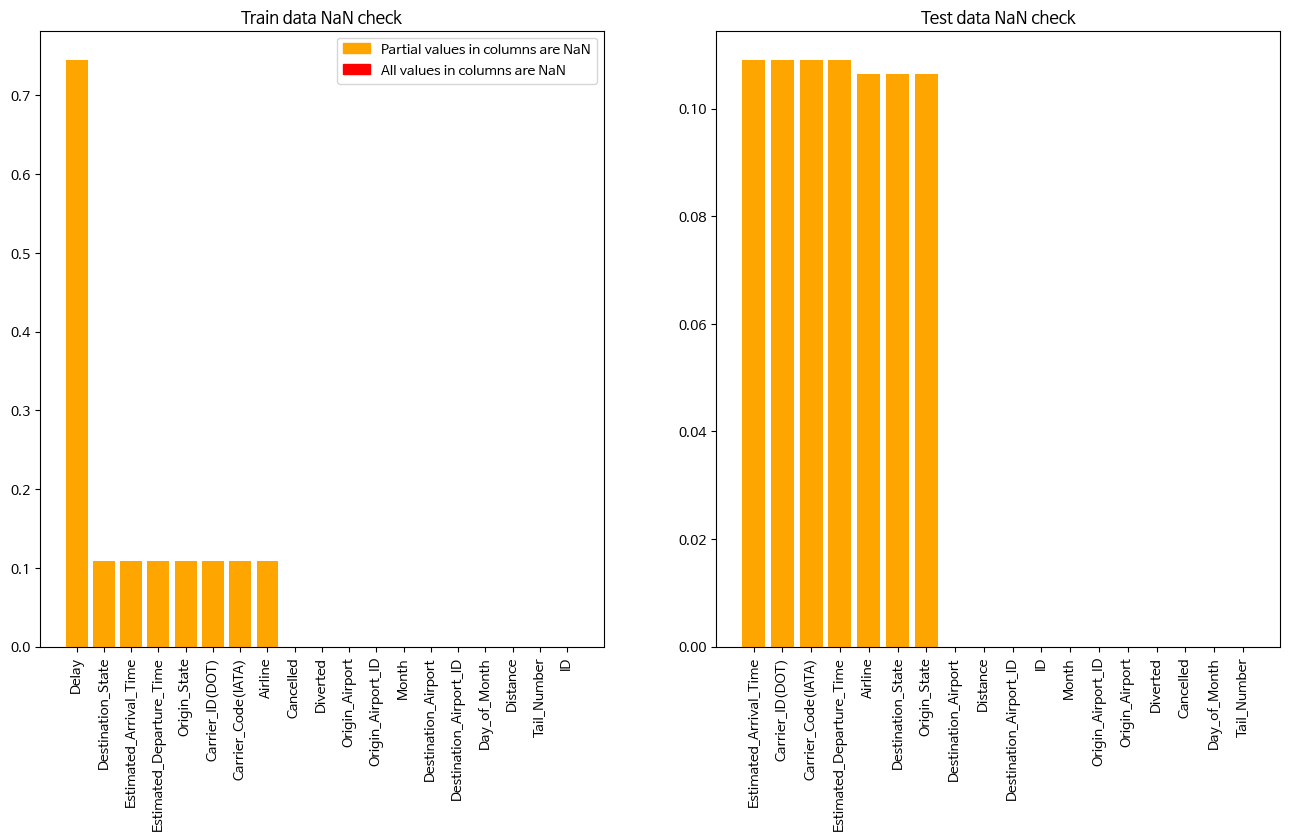

In [458]:
import matplotlib
matplotlib.rcParams['font.family'] = 'NanumBarunGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

column = ['결손값 개수']
axis_1 = pd.DataFrame(data = train.isnull().sum(axis=1), columns = column)
axis_1 = axis_1.sort_values(by = '결손값 개수', ascending = False)

train.isnull().sum(axis=0)
train_row_NaN = pd.DataFrame(train.isnull().sum(axis=0), columns = column)
train_row_NaN = train_row_NaN.sort_values(by = '결손값 개수', ascending = False)
train_row_su = train.shape[0]
train_row_NaN['결손값_ratio'] = train_row_NaN['결손값 개수']/train_row_su

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize = (16,8))
x = np.arange(len(train_row_NaN.index))
plt.subplot(1, 2, 1)
plt.xticks(x, train_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])

def color(data):
    if data == 1:
        return 'red'
    else:
        return 'orange'
plt.bar(x, train_row_NaN['결손값_ratio'], color = [color(i) for i in train_row_NaN['결손값_ratio']])
plt.title('Train data NaN check')

test.isnull().sum(axis=0)
test_row_NaN = pd.DataFrame(test.isnull().sum(axis=0), columns = column)
test_row_NaN = test_row_NaN.sort_values(by = '결손값 개수', ascending = False)
test_row_su = test.shape[0]
test_row_NaN['결손값_ratio'] = test_row_NaN['결손값 개수']/test_row_su

plt.subplot(1, 2, 2)
x2 = np.arange(len(test_row_NaN.index))
plt.xticks(x2, test_row_NaN.index)
plt.xticks(rotation=90)
plt.bar(x2, test_row_NaN['결손값_ratio'], color = [color(i) for i in test_row_NaN['결손값_ratio']])
plt.title('Test data NaN check')

print(test_row_NaN)
print(train_row_NaN)
plt.show()

Delay (key)값의 누락은 정확한 예측이 불가능하므로, 해당 Delay의 null을 최대한 채울 수 있으면 좋다.

해당 작업을 하기 전에, 출발 도시와 도착 도시의 null을 분석하여 채워넣는다.
또한 예상 출발, 도착 시간은 항공사/비행기 마다 다르므로, 값을 어떻게 대체할 지 고민이 필요하다.

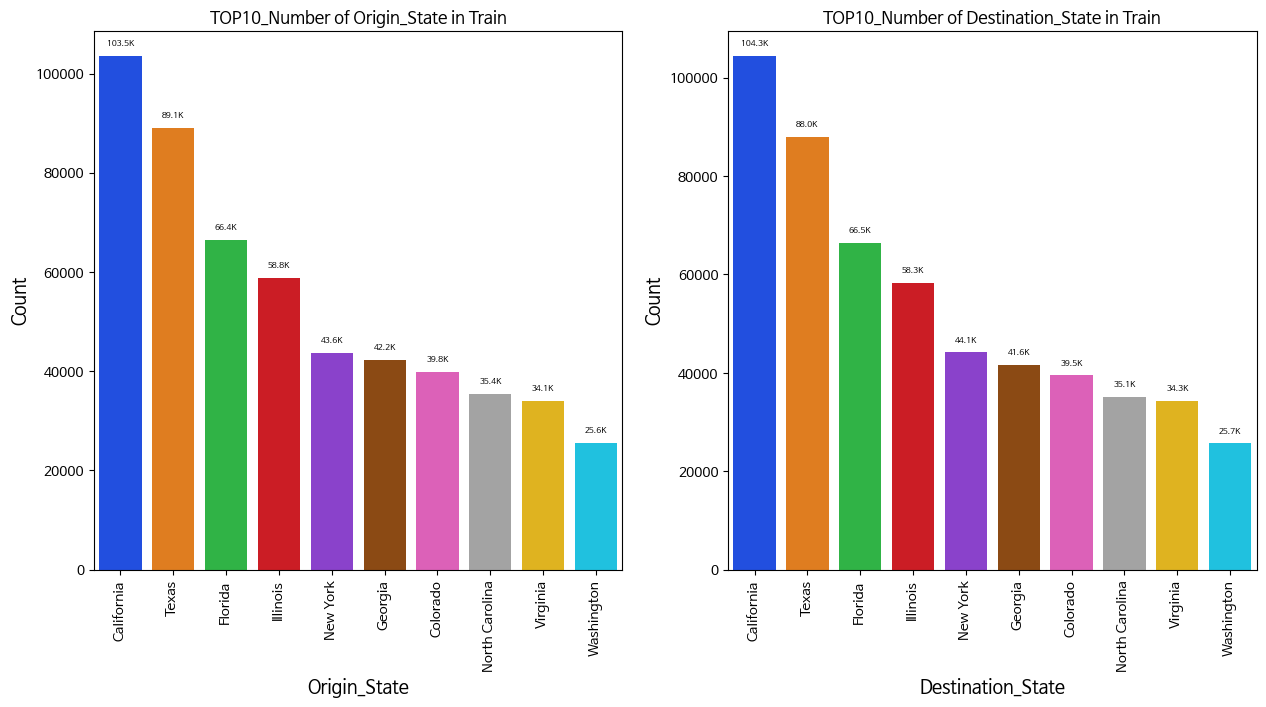

In [459]:
# ID 관련 구분좌 개수
def km_gb(value):
    if value < 1e6:
        return format((value/1e3), '.01f')+"K"
    else:
        return format((value/1e6), '.01f')+"M"

import seaborn as sns

# Origin_State, Destination_State 개수
train_origin = train.groupby("Origin_State").size()

train_origin = train_origin.reset_index()
train_origin.columns = ["state", "count"]
train_origin = train_origin.sort_values(by = "count", ascending = False)
train_origin['rank'] = train_origin['count'].rank(ascending=False) 
train_origin = train_origin[train_origin['rank']<= 10]

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
splot=sns.barplot(x="state",y="count",data = train_origin)
for p in splot.patches:
    splot.annotate(km_gb(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=6,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Origin_State", size =13)
plt.xticks(rotation = 90)
plt.ylabel("Count",size =13)
plt.title('TOP10_Number of Origin_State in Train')

train_destrination = train.groupby("Destination_State").size()
train_destrination = train_destrination.reset_index()
train_destrination.columns = ["state", "count"]
train_destrination = train_destrination.sort_values(by = "count", ascending = False)
train_destrination['rank'] = train_destrination['count'].rank(ascending=False) 
train_destrination = train_destrination[train_destrination['rank']<= 10]

plt.subplot(1, 2, 2)
splot=sns.barplot(x="state",y="count",data=train_destrination)
for p in splot.patches:
    splot.annotate(km_gb(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=6,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Destination_State", size =13)
plt.xticks(rotation = 90)
plt.ylabel("Count",size =13)
plt.title('TOP10_Number of Destination_State in Train')

plt.show()

In [460]:
not_dly_train = train[train.Delay == 'Not_Delayed']
dly_train = train[train.Delay == 'Delayed']
non_train = train[~(train.Delay == 'Delayed')&~(train.Delay == 'Not_Delayed')]

In [461]:
list = []
for i in range(3):
    list.append(eval('node_list{:}'.format(i+1)))

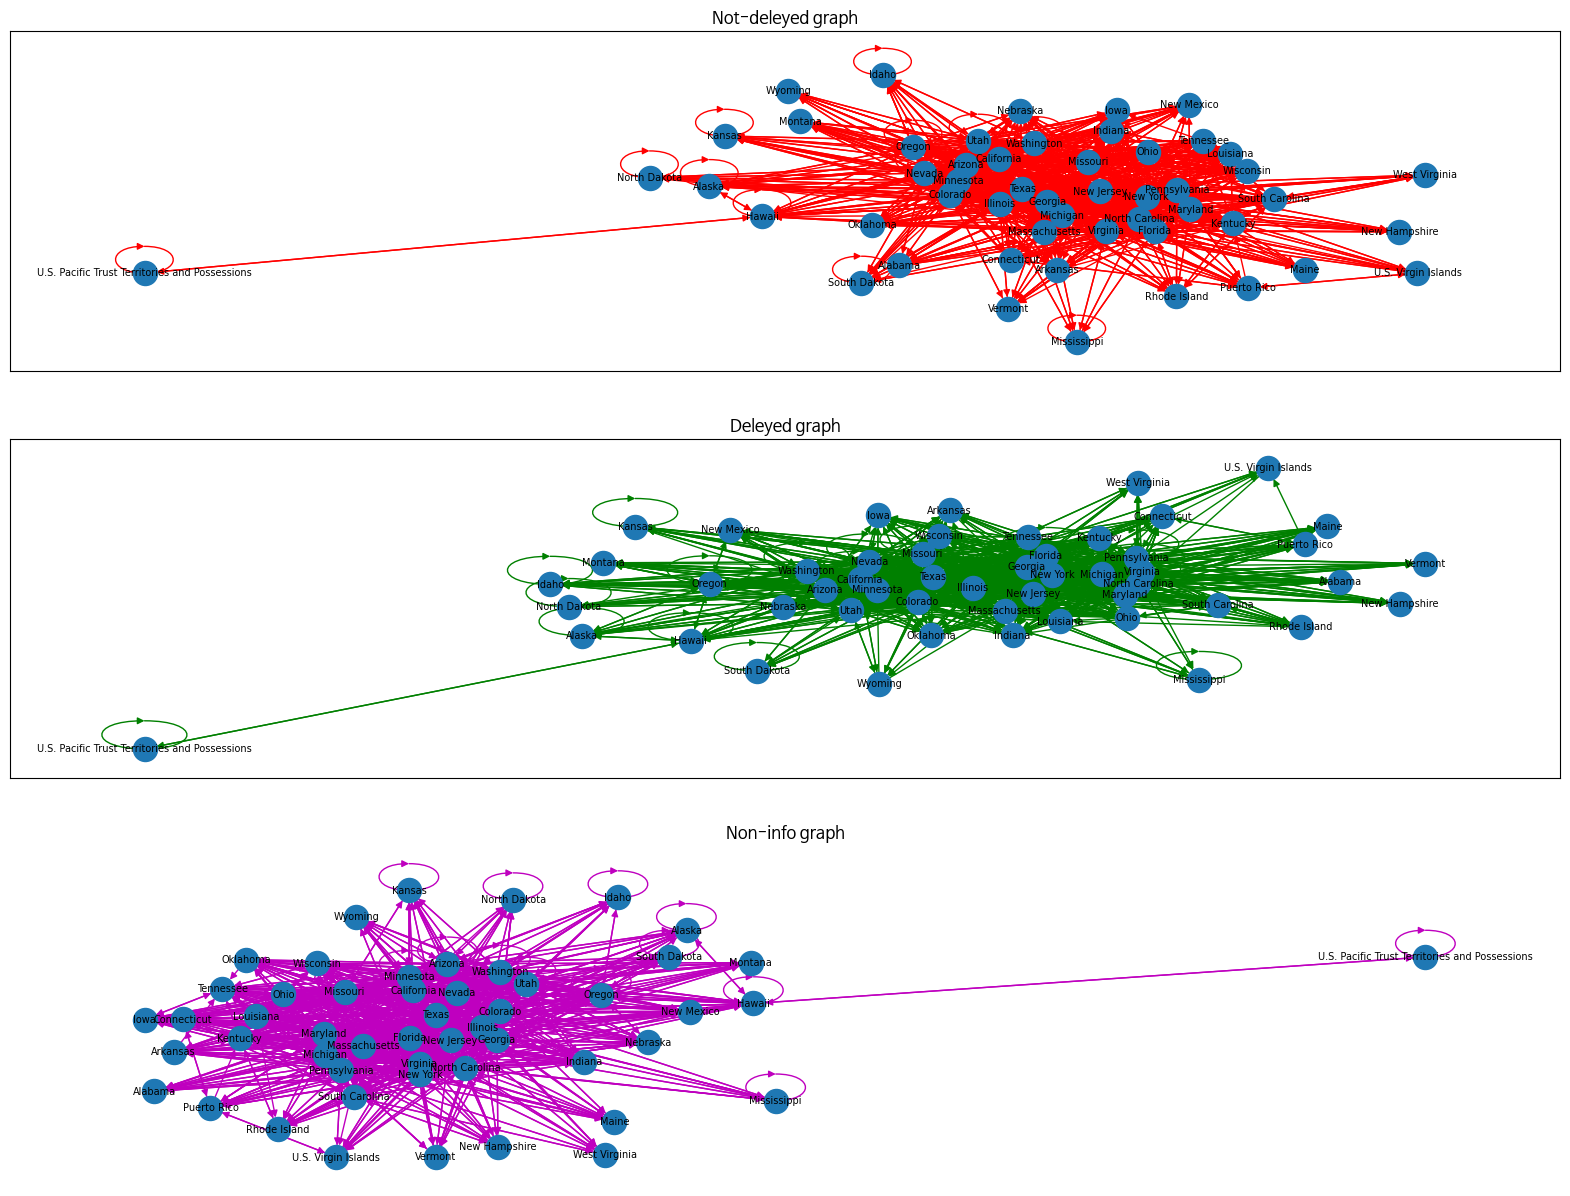

In [462]:
# 항공편 이동 노드화

import networkx as nx
import matplotlib.pyplot as plt

# 노드와 엣지 리스트 정의
node_list1 = []
edge_list1 = []
node_list2 = []
edge_list2 = []
node_list3 = []
edge_list3 = []

f, axs = plt.subplots(3,1,figsize=(20,15))

# Origin_State와 Destination_State 페어 리스트
pairs1 = [(i,j) for i,j in zip(not_dly_train['Origin_State'], not_dly_train['Destination_State']) if (i != None and j != None)] # 딜레이 되지 않음
pairs2 = [(i,j) for i,j in zip(dly_train['Origin_State'], dly_train['Destination_State']) if (i != None and j != None)] # 딜레이 됨
pairs3 = [(i,j) for i,j in zip(non_train['Origin_State'], non_train['Destination_State']) if (i != None and j != None)] # 딜레이 정보 없음

# 노드와 엣지 리스트에 페어 추가
for pair in pairs1:
    origin, destination = pair
    node_list1 += [origin, destination]
    edge_list1.append(pair)

# 노드 중복 제거
node_list1 = set(node_list1)

# 노드와 엣지로 그래프 생성
G = nx.DiGraph()
G.add_nodes_from(node_list1)
G.add_edges_from(edge_list1)

# 그래프 시각화
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300, ax=axs[0])
nx.draw_networkx_labels(G, pos, font_size=7, ax=axs[0])
nx.draw_networkx_edges(G, pos, edge_color='r', arrows=True, ax=axs[0])


for pair in pairs2:
    origin, destination = pair
    node_list2 += [origin, destination]
    edge_list2.append(pair)

# 노드 중복 제거
node_list2 = set(node_list2)

# 노드와 엣지로 그래프 생성
L = nx.DiGraph()
L.add_nodes_from(node_list2)
L.add_edges_from(edge_list2)

# 그래프 시각화
pos = nx.spring_layout(L)
nx.draw_networkx_nodes(L, pos, node_size=300, ax=axs[1])
nx.draw_networkx_labels(L, pos, font_size=7, ax=axs[1])
nx.draw_networkx_edges(L, pos, edge_color='g', arrows=True, ax=axs[1])

for pair in pairs3:
    origin, destination = pair
    node_list3 += [origin, destination]
    edge_list3.append(pair)

# 노드 중복 제거
node_list3 = set(node_list3)

# 노드와 엣지로 그래프 생성
H = nx.DiGraph()
H.add_nodes_from(node_list3)
H.add_edges_from(edge_list3)

# 그래프 시각화
pos = nx.spring_layout(H)
nx.draw_networkx_nodes(H, pos, node_size=300, ax=axs[2])
nx.draw_networkx_labels(H, pos, font_size=7, ax=axs[2])
nx.draw_networkx_edges(H, pos, edge_color='m', arrows=True, ax=axs[2])

axs[0].set_title('Not-deleyed graph')
axs[1].set_title('Deleyed graph')
axs[2].set_title('Non-info graph')

plt.axis('off')
plt.show()

출발 도시와 도착 도시가 null인 노드를 제외한 페어를 노드화하여 도식화함.

>> 출발과 도착의 도시가 같은 경우가 존재함. 꼭 다른 도시로 이동한다는 보장 X
>> 그리고 출발 비행기와 도착 비행기가 다르다 이건 환승을 의미하는 것인가? 아니면 왕복을 말하는 것인가?

재밌는 사실은 해당 데이터에서 

* Estimated_Departure_Time
* Estimated_Arrival_Time

은 겉보기에 분으로 계산된 것 같지만, 실제로 HHMM의 형태를 이루고 있다. 

In [463]:
print(train[(train['Estimated_Departure_Time']<0) & (train['Estimated_Departure_Time']>2400)])
print(train[(train['Estimated_Arrival_Time']<0) & (train['Estimated_Arrival_Time']>2400)])

Empty DataFrame
Columns: [ID, Month, Day_of_Month, Estimated_Departure_Time, Estimated_Arrival_Time, Cancelled, Diverted, Origin_Airport, Origin_Airport_ID, Origin_State, Destination_Airport, Destination_Airport_ID, Destination_State, Distance, Airline, Carrier_Code(IATA), Carrier_ID(DOT), Tail_Number, Delay]
Index: []
Empty DataFrame
Columns: [ID, Month, Day_of_Month, Estimated_Departure_Time, Estimated_Arrival_Time, Cancelled, Diverted, Origin_Airport, Origin_Airport_ID, Origin_State, Destination_Airport, Destination_Airport_ID, Destination_State, Distance, Airline, Carrier_Code(IATA), Carrier_ID(DOT), Tail_Number, Delay]
Index: []


따라서 시간을 만들기 전에 해당 데이터를 시간화해주는 작업과 예상 비행시간을 만들어줘야한다.

In [464]:
import datetime
def to_time(time_list):
    Time = pd.Series(time_list).astype(str).str.zfill(4)
    Time = Time.replace('2400','0000')
    return [datetime.datetime.strptime(i, '%H%M').strftime("%H:%M") if i != '0nan' else np.NaN for i in Time] 

time_list = [i if str(i) == 'nan' else str(int(i))  for i in train['Estimated_Departure_Time'] ]
time_list1 = [i if str(i) == 'nan' else str(int(i))  for i in train['Estimated_Arrival_Time'] ]
train['Estimated_Departure_Time_HH:MM'] = to_time(time_list)
train['Estimated_Arrival_Time_HH:MM'] = to_time(time_list1)
train


,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,...,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Estimated_Departure_Time_HH:MM,Estimated_Arrival_Time_HH:MM
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,...,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None,NaN,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,...,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None,07:40,10:24
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,...,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None,16:10,18:05
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,...,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None,09:05,17:35
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,...,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None,09:00,10:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,936.0,1243.0,0,0,ORD,13930,None,...,14100,None,678.0,United Air Lines Inc.,UA,19977.0,N477UA,None,09:36,12:43
999996,TRAIN_999996,5,30,920.0,1028.0,0,0,FAR,11637,None,...,13487,Minnesota,223.0,SkyWest Airlines Inc.,DL,NaN,N439SW,None,09:20,10:28
999997,TRAIN_999997,6,28,800.0,1340.0,0,0,OAK,13796,None,...,12191,Texas,1642.0,Southwest Airlines Co.,WN,19393.0,N230WN,None,08:00,13:40
999998,TRAIN_999998,9,27,1613.0,1824.0,0,0,BNA,10693,Tennessee,...,10397,None,214.0,Delta Air Lines Inc.,DL,19790.0,N968DL,None,16:13,18:24


In [465]:
time = datetime.datetime.strptime('05:30', "%H:%M") - datetime.datetime.strptime('21:30', "%H:%M") + datetime.datetime.strptime('23:59', "%H:%M") + datetime.timedelta(minutes=1)
datetime.timedelta(hours=time.hour,minutes=time.minute ).total_seconds()/60

480.0

In [466]:
# 예상 비행시간 만들기 (분으로 만들기)
train_est_time = []
for i,j in zip(train['Estimated_Arrival_Time_HH:MM'], train['Estimated_Departure_Time_HH:MM']):
    if str(i) != 'nan' and str(j) != 'nan':
        if (datetime.datetime.strptime(str(i), "%H:%M") - datetime.datetime.strptime(str(j), "%H:%M")).total_seconds()/60 >= 0:
            train_est_time.append((datetime.datetime.strptime(str(i), "%H:%M") - datetime.datetime.strptime(str(j), "%H:%M")).total_seconds()/60)
        else:
            time = datetime.datetime.strptime(str(i), "%H:%M") - datetime.datetime.strptime(str(j), "%H:%M") + datetime.datetime.strptime('23:59', "%H:%M") + datetime.timedelta(minutes=1)
            train_est_time.append(datetime.timedelta(hours=time.hour,minutes=time.minute ).total_seconds()/60)
    else:
        train_est_time.append(np.NaN)
 

In [467]:
train['Estimated_Time'] = train_est_time

In [468]:
train[(train['Origin_State'] == 'Oklahoma') & (train['Destination_State'] == 'Texas')][train['Estimated_Departure_Time'] == 1400].sort_values(by = ['Month', 'Day_of_Month', 'Estimated_Departure_Time', 'Tail_Number'])

<ipython-input-468-734350ff2c72>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train[(train['Origin_State'] == 'Oklahoma') & (train['Destination_State'] == 'Texas')][train['Estimated_Departure_Time'] == 1400].sort_values(by = ['Month', 'Day_of_Month', 'Estimated_Departure_Time', 'Tail_Number'])


,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,...,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Estimated_Departure_Time_HH:MM,Estimated_Arrival_Time_HH:MM,Estimated_Time
801918,TRAIN_801918,1,1,1400.0,1540.0,0,0,TUL,15370,Oklahoma,...,Texas,429.0,ExpressJet Airlines Inc.,None,NaN,N14907,None,14:00,15:40,100.0
471401,TRAIN_471401,1,1,1400.0,1505.0,0,0,OKC,13851,Oklahoma,...,Texas,175.0,Mesa Airlines Inc.,None,20378.0,N247LR,None,14:00,15:05,65.0
522032,TRAIN_522032,1,5,1400.0,1540.0,0,0,TUL,15370,Oklahoma,...,Texas,429.0,None,UA,NaN,N13989,None,14:00,15:40,100.0
389640,TRAIN_389640,1,7,1400.0,1530.0,0,0,OKC,13851,Oklahoma,...,Texas,395.0,ExpressJet Airlines Inc.,UA,20366.0,N19554,Not_Delayed,14:00,15:30,90.0
330154,TRAIN_330154,1,10,1400.0,1540.0,0,0,TUL,15370,Oklahoma,...,Texas,429.0,ExpressJet Airlines Inc.,UA,20366.0,N13908,None,14:00,15:40,100.0
367165,TRAIN_367165,1,18,1400.0,1530.0,0,0,OKC,13851,Oklahoma,...,Texas,395.0,ExpressJet Airlines Inc.,UA,20366.0,N15912,None,14:00,15:30,90.0
355711,TRAIN_355711,1,26,1400.0,1533.0,0,0,OKC,13851,Oklahoma,...,Texas,395.0,Republic Airlines,None,20452.0,N859RW,Not_Delayed,14:00,15:33,93.0
621149,TRAIN_621149,1,29,1400.0,1533.0,0,0,OKC,13851,Oklahoma,...,Texas,395.0,Republic Airlines,UA,20452.0,N635RW,None,14:00,15:33,93.0
255369,TRAIN_255369,1,31,1400.0,1530.0,0,0,OKC,13851,Oklahoma,...,Texas,395.0,ExpressJet Airlines Inc.,UA,20366.0,N14904,None,14:00,15:30,90.0
963737,TRAIN_963737,2,4,1400.0,1533.0,0,0,OKC,13851,Oklahoma,...,Texas,395.0,ExpressJet Airlines Inc.,UA,NaN,N18557,None,14:00,15:33,93.0


Oklahoma에서 Texas로 가능 비행편을 시간순으로 조회한 다음, Tail_Number로 정렬했더니, 같은 비행편이라도 같은 시간에 출발한 비행기가 항공사마다 다른 점을 발견.

>> 항공사마다 시간이 다르고, 함부로 Null값을 대체하면 안될 것 같음. 

<AxesSubplot: >

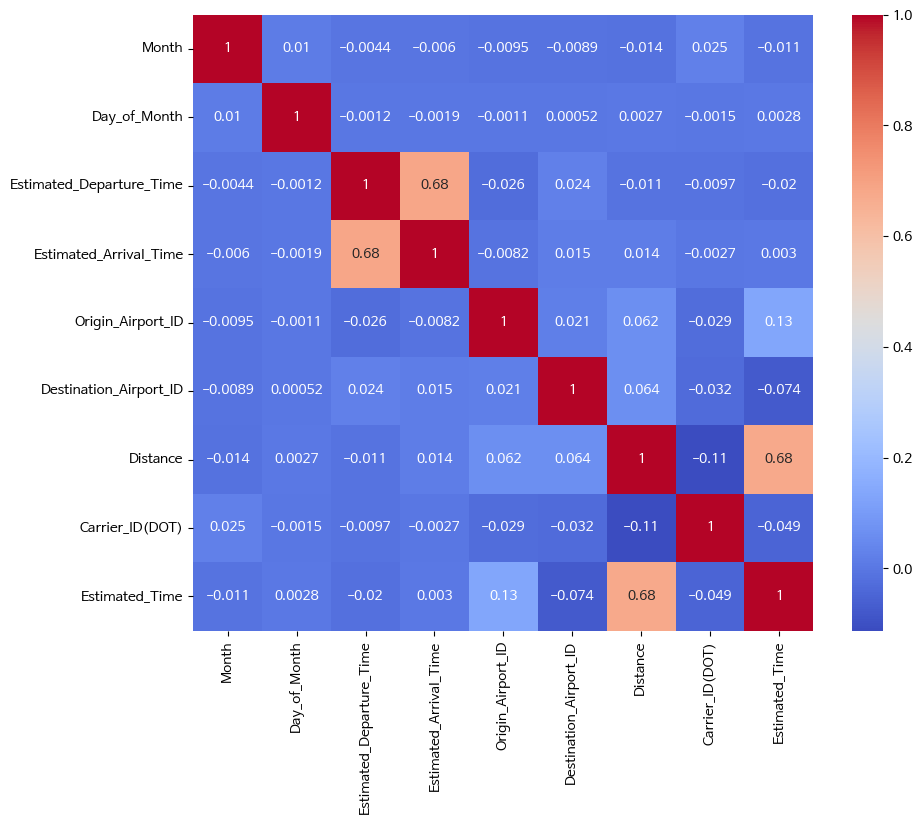

In [469]:
f, ax = plt.subplots(figsize=(10, 8))
corr = train.copy().drop(labels = ['Cancelled', 'Diverted'], axis = 1).corr()
sns.heatmap(corr,
            cmap='coolwarm',
            annot = True,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values)

array([[<AxesSubplot: title={'center': 'Month'}>,
        <AxesSubplot: title={'center': 'Day_of_Month'}>,
        <AxesSubplot: title={'center': 'Estimated_Departure_Time'}>],
       [<AxesSubplot: title={'center': 'Estimated_Arrival_Time'}>,
        <AxesSubplot: title={'center': 'Origin_Airport_ID'}>,
        <AxesSubplot: title={'center': 'Destination_Airport_ID'}>],
       [<AxesSubplot: title={'center': 'Distance'}>,
        <AxesSubplot: title={'center': 'Carrier_ID(DOT)'}>,
        <AxesSubplot: title={'center': 'Estimated_Time'}>]], dtype=object)

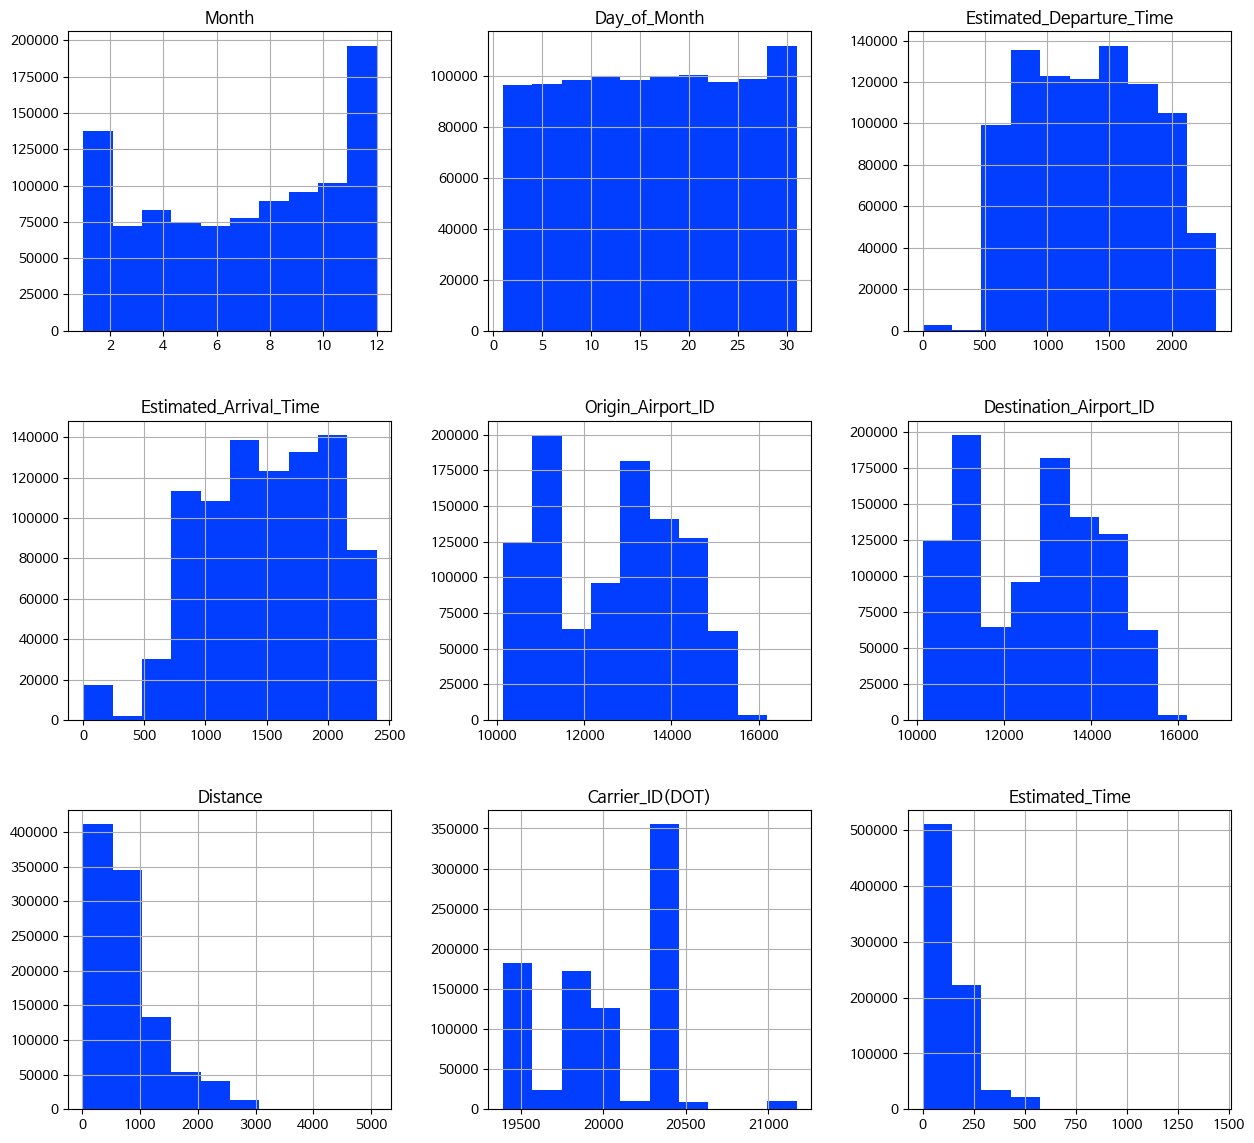

In [470]:
train.copy().drop(labels = ['Cancelled', 'Diverted'], axis = 1).hist(figsize= (15, 14))


1월과 2월 사이, 11월과 12월 사이에 가장 많은 여행을 보였으며, 

노선의 구분을 다음과 같이 정의 할 때, (Eurocontrol 기준)
* 장거리: 4000km 이상
* 중거리: 1500 ~ 4000km 미만
* 단거리: 1500km 미만

으로 볼 때, 단거리 비행이 가장 빈번하게 발생하는 것을 볼 수 있다. 또한, 예상 비행시간이 125분 미만(2시간 5분)이 가장 많으므로, 단거래 비행이 다수임을 뒷바침해준다.

array([[<AxesSubplot: title={'center': 'Month'}>,
        <AxesSubplot: title={'center': 'Day_of_Month'}>,
        <AxesSubplot: title={'center': 'Estimated_Departure_Time'}>],
       [<AxesSubplot: title={'center': 'Estimated_Arrival_Time'}>,
        <AxesSubplot: title={'center': 'Origin_Airport_ID'}>,
        <AxesSubplot: title={'center': 'Destination_Airport_ID'}>],
       [<AxesSubplot: title={'center': 'Distance'}>,
        <AxesSubplot: title={'center': 'Carrier_ID(DOT)'}>,
        <AxesSubplot: title={'center': 'Estimated_Time'}>]], dtype=object)

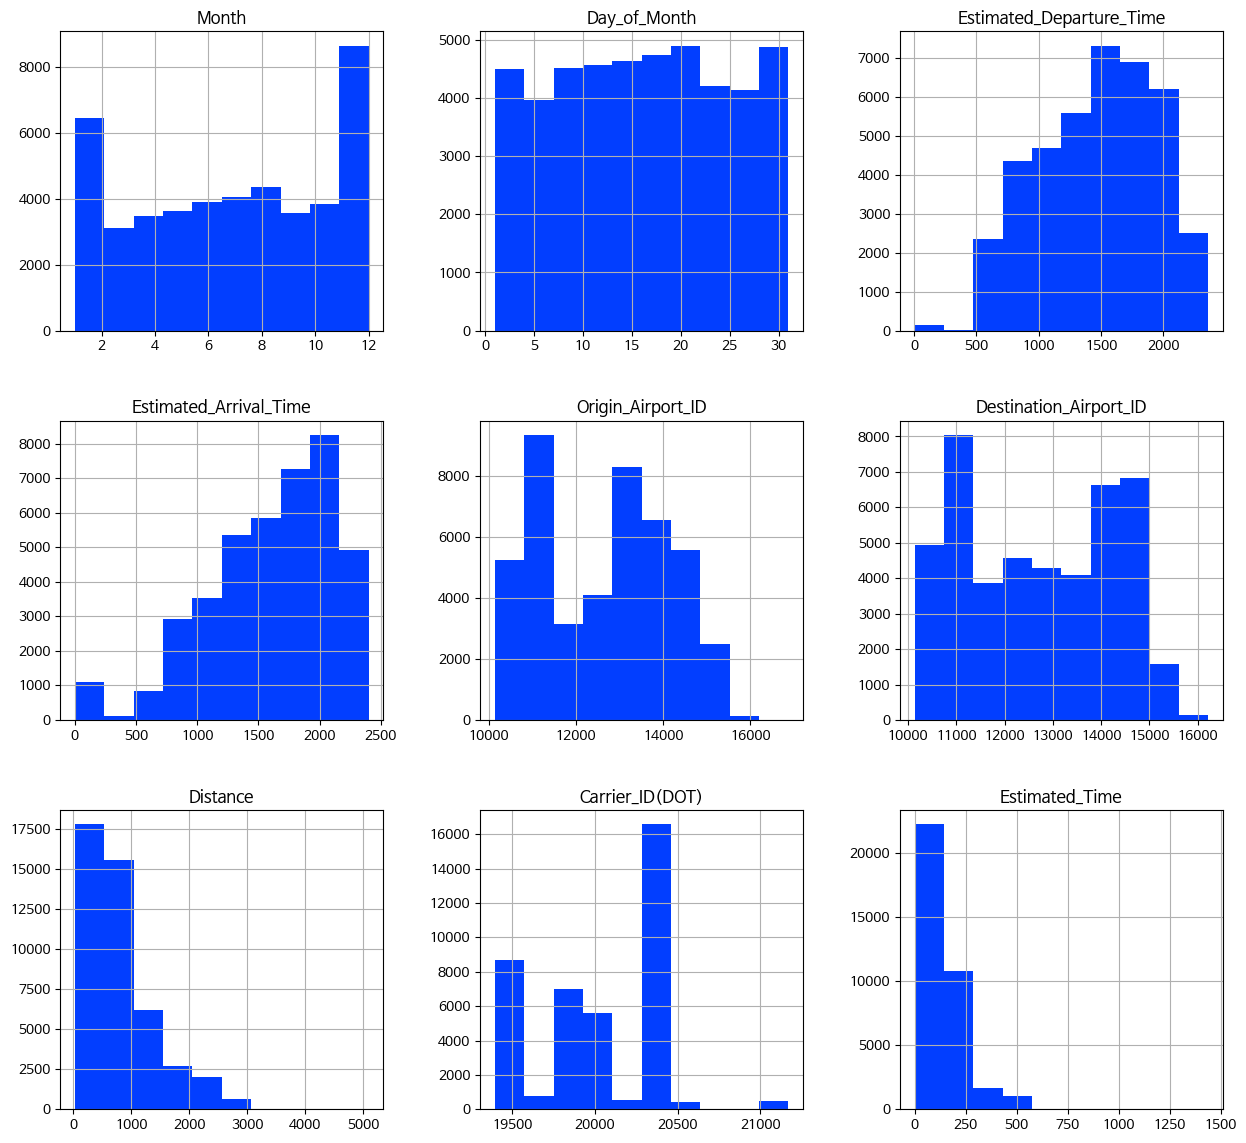

In [471]:
train[train.Delay == 'Delayed'].drop(labels = ['Cancelled', 'Diverted'], axis = 1).hist(figsize= (15, 14))

특히 비행기가 지연된 case에서 예상 출발 시간이 오후 8시에 가장 많이 딜레이 됐고, 예상 도착 시간이 오후 3시일 때 가장 많이 딜레이가 된 모습니다.